##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generating semi-transparent Feature Visualizations

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to produce semi-transparent feature visualizations using a [Differentiable Image Parameterization](https://distill.pub/2018/differentiable-parameterizations/#section-xy2rgb) with an extra **alpha channel**.

![](https://storage.googleapis.com/tensorflow-lucid/notebooks/rgba/rgba-header.jpg)

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install, Import, and load a model

In [3]:
!pip install -q lucid>=0.2.3

In [4]:
!pip install -q moviepy
!imageio_download_bin ffmpeg

Ascertaining binaries for: ffmpeg.


In [0]:
from __future__ import print_function
from io import BytesIO
import numpy as np
import PIL

import matplotlib.pylab as pl

from google.colab import files

import tensorflow as tf
from tensorflow.contrib import slim

from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
import moviepy.editor as mvp

from IPython.display import clear_output, Image, display

In [0]:
from lucid.modelzoo import vision_models
from lucid.misc.io import load, save, show
from lucid.optvis import objectives, transform
from lucid.optvis.param import image, image_sample
from lucid.misc.tfutil import create_session

In [0]:
model = vision_models.InceptionV1()
model.load_graphdef()

# Utilities

We'll need two simple but non-standard tools to work with:

## Checkerboard patterns

A common way to show transparency is by overlaying the transparent image on a checkerboard pattern:

![](https://storage.googleapis.com/tensorflow-lucid/notebooks/rgba/checkerboard-pattern.png)

Let's start by making sure we can generate those at arbitrary sizes.

In [0]:
from math import ceil

def checkerboard(h, w=None, channels=3, tiles=4, fg=.95, bg=.6):
  """Create a shape (w,h,1) array tiled with a checkerboard pattern."""
  w = w or h
  square_size = [ceil(float(d / tiles) / 2) for d in [h, w]]
  board = [[fg, bg] * tiles, [bg, fg] * tiles] * tiles
  scaled = np.kron(board, np.ones(square_size))[:w, :h]
  return np.dstack([scaled]*channels)


Colors: (1.0, 0.0)



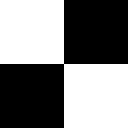
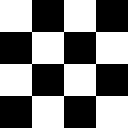
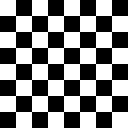
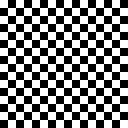


Colors: (0.95, 0.6)



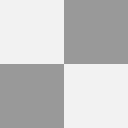
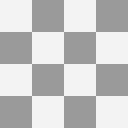
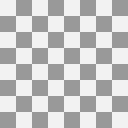
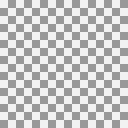

In [5]:
for fg, bg in [(1., 0.), (.95, .6)]:
  print("\nColors: {}".format((fg, bg)))
  show([checkerboard(128, fg=fg, bg=bg, tiles=i) 
        for i in (1, 2, 4, 8)])

## Collapse transparency
…and make a nice visualization grid with the transparent image overlaid on black, white, and our checkerboard pattern.

In [0]:
def linear2gamma(a):
  return a**(1.0/2.2)

def gamma2linear(a):
  return a**2.2


def composite_alpha_onto_backgrounds(rgba,
                                     input_encoding='gamma',
                                     output_encoding='gamma'):
  if input_encoding == 'gamma':
    rgba = rgba.copy()
    rgba[..., :3] = gamma2linear(rgba[..., :3])
    
  h, w = rgba.shape[:2]
  
  # Backgrounds
  black = np.zeros((h, w, 3), np.float32)
  white = np.ones((h, w, 3), np.float32)
  grid = checkerboard(h, w, 3, tiles=8)
  
  # Collapse transparency onto backgrounds
  rgb, a = rgba[...,:3], rgba[...,3:]
  vis = [background*(1.0-a) + rgb*a for background in [black, white, grid]]
  vis.append(white*a) # show just the alpha channel separately
  
  # Reshape into 2x2 grid
  vis = np.float32(vis).reshape(2, 2, h, w, 3)
  vis = np.vstack(map(np.hstack, vis))
  if output_encoding == 'gamma':
    vis = linear2gamma(vis)
  return vis

Let's try it with a simple image with transparency:


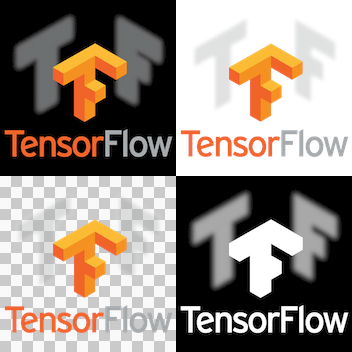

In [20]:
rgba_image = load("https://storage.googleapis.com/tensorflow-lucid/notebooks/rgba/rgba-example.png")
show(composite_alpha_onto_backgrounds(rgba_image))

# Semi-transparent Feature Visualizations

When compositing transparent images onto backgrounds we should take the non-linear relationship between numerical values representing colors, and the real light intensities into account. The Wikipedia entries on [Alpha Compositing](https://en.wikipedia.org/wiki/Alpha_compositing#Composing_alpha_blending_with_gamma_correction) and on [Gamma Correction](https://en.wikipedia.org/wiki/Gamma_correction) come in handy if you want a refresher. Otherwise you should be able to understand everything that happens here without that background knowledge, too.

In [0]:
def render(obj_str, iter_n=1000):
  sess = create_session()

  def T(layer):
    return sess.graph.get_tensor_by_name("import/%s:0"%layer)

  w, h = 320, 320
  t_image = image(h, w, decorrelate=True, fft=True, alpha=True)
  t_rgb = t_image[...,:3]
  t_alpha = t_image[...,3:]
  t_bg = image_sample([1, h, w, 3], sd=0.2, decay_power=1.5)

  t_composed = t_bg*(1.0-t_alpha) + t_rgb*t_alpha
  t_composed = tf.concat([t_composed, t_alpha], -1)
  t_crop = transform.random_scale([0.6, 0.7, 0.8, 0.9, 1.0, 1.1])(t_composed)
  t_crop = tf.random_crop(t_crop, [1, 160, 160, 4])
  t_crop_rgb, t_crop_alpha = t_crop[..., :3], t_crop[..., 3:]
  t_crop_rgb = linear2gamma(t_crop_rgb)
  model.import_graph(t_crop_rgb)

  obj = objectives.as_objective(obj_str)(T)
  t_alpha_mean_crop = tf.reduce_mean(t_crop_alpha)
  t_alpha_mean_full = tf.reduce_mean(t_alpha)
  tf.losses.add_loss(-obj*(1.0-t_alpha_mean_full)*0.5)
  tf.losses.add_loss(-obj*(1.0-t_alpha_mean_crop))


  t_lr = tf.constant(0.01)
  t_loss = tf.losses.get_total_loss()
  trainer = tf.train.AdamOptimizer(t_lr)
  train_op = trainer.minimize(t_loss)

  init_op = tf.global_variables_initializer()
  init_op.run()
  log = []

  out_name = obj_str.replace(':', '_')
  writer = FFMPEG_VideoWriter(out_name+'.mp4', (w*2, h*2), 60.0)
  with writer:
    for i in range(iter_n):
      _, loss, img = sess.run([train_op, t_loss, t_image], {t_lr: 0.03})
      vis = composite_alpha_onto_backgrounds(img[0], 'linear', 'gamma')
      writer.write_frame(np.uint8(vis*255.0))
      log.append(loss)
      if i%100 == 0:
        clear_output()
        print(len(log), loss)
        vis = t_composed.eval()[...,:3]
        vis = linear2gamma(vis)
        show(vis)

  img = t_image.eval()[0]
  vis = composite_alpha_onto_backgrounds(img, 'linear', 'gamma')
  img[..., :3] = linear2gamma(img[..., :3])
  show(vis)
  save(img, out_name+'.png')

  alpha = img[...,3]
  alpha = np.dstack([alpha]*3)
  joined = np.hstack([img[...,:3], alpha])
  save(joined, out_name+'.jpg', quality=90)

  return log

901 -420.05374



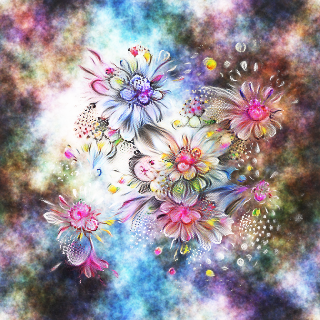


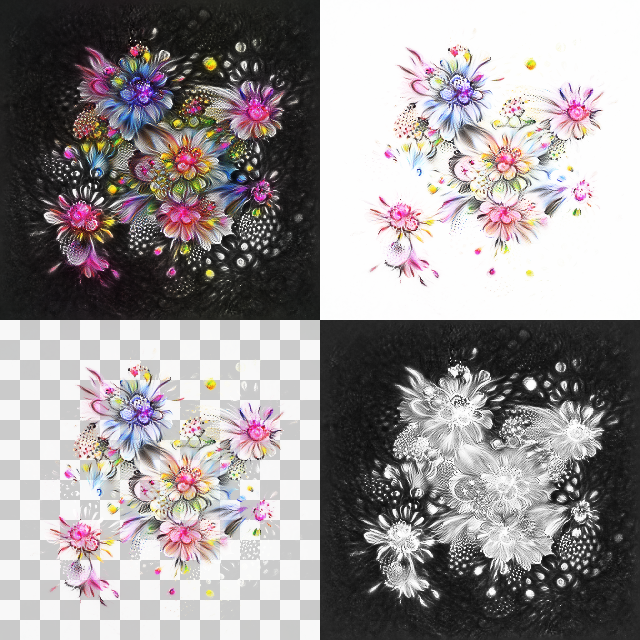

In [22]:
loss_log = render('mixed4d_3x3_bottleneck_pre_relu:139')

That seems to have worked! Let's quickly check that the loss went down during optimization:

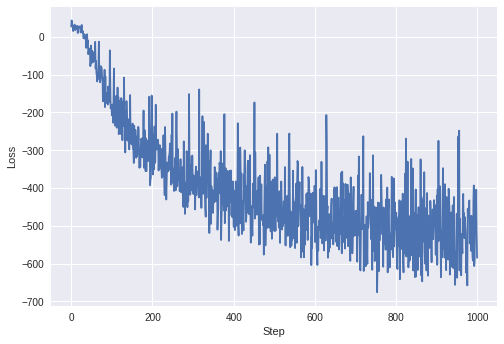

In [33]:
pl.plot(loss_log)
pl.xlabel('Step')
pl.ylabel('Loss');

Let's view the video of the optimizations process! The video is set up at 60 frames per second, one frame per optimization step, and our optimization ran for 1000 steps. As a sanity check, the video should be roughly 1000 frames/60fps =~ 16s long.

In [34]:
mvp.ipython_display('mixed4d_3x3_bottleneck_pre_relu_139.mp4', height=320*2)

## Additional interesting patterns

In [0]:
render('mixed4b_pool_reduce_pre_relu:16')

In [0]:
render('mixed4b_pool_reduce_pre_relu:27')

In [0]:
render('mixed4b_pool_reduce_pre_relu:14')

In [0]:
render('mixed4b_pool_reduce_pre_relu:40')

In [0]:
render('mixed4b_pool_reduce_pre_relu:46')

In [0]:
render('mixed4a_pool_reduce_pre_relu:15')

In [0]:
render('mixed4a_pool_reduce_pre_relu:52')

In [0]:
render('mixed4a_pool_reduce_pre_relu:29')

## Downloading results

In [47]:
ls -lh

total 20M
drwxr-xr-x 1 root root 4.0K Jun 19 16:42 datalab/
-rw-r--r-- 1 root root 2.0M Jun 21 14:11 mixed4a_pool_reduce_pre_relu_15.mp4
-rw-r--r-- 1 root root 286K Jun 21 14:11 mixed4a_pool_reduce_pre_relu_15.png
-rw-r--r-- 1 root root 2.1M Jun 21 14:15 mixed4a_pool_reduce_pre_relu_29.mp4
-rw-r--r-- 1 root root 276K Jun 21 14:15 mixed4a_pool_reduce_pre_relu_29.png
-rw-r--r-- 1 root root 1.7M Jun 21 14:13 mixed4a_pool_reduce_pre_relu_52.mp4
-rw-r--r-- 1 root root 281K Jun 21 14:13 mixed4a_pool_reduce_pre_relu_52.png
-rw-r--r-- 1 root root 1.9M Jun 21 14:04 mixed4b_pool_reduce_pre_relu_14.mp4
-rw-r--r-- 1 root root 270K Jun 21 14:04 mixed4b_pool_reduce_pre_relu_14.png
-rw-r--r-- 1 root root 1.9M Jun 21 13:58 mixed4b_pool_reduce_pre_relu_16.mp4
-rw-r--r-- 1 root root 277K Jun 21 13:58 mixed4b_pool_reduce_pre_relu_16.png
-rw-r--r-- 1 root root 2.0M Jun 21 14:02 mixed4b_pool_reduce_pre_relu_27.mp4
-rw-r--r-- 1 root root 274K Jun 21 14:02 mixed4b_pool_reduce_pre_relu_27.png
-rw-r--r-- 1 roo

In [48]:
from glob import glob
for fn in glob('*.png')+glob('*.mp4'):
  files.download(fn)